In [ ]:
import os
import sys
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

sns.set()
sns.set_style("ticks")
sns.set_context("paper", font_scale = 1.5)
plt.rcParams['text.usetex'] = True
plt.rcParams['font.size'] = 20

import torch
from torch import nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch import Tensor
from torch.nn.parameter import Parameter, UninitializedParameter
from torch.nn import functional as F
from torch.nn import init
from torch.nn import Module
import FrEIA.framework as Ff
import FrEIA.modules as Fm
from sklearn.model_selection import train_test_split

#print('Python', sys.version)

Python 3.12.2 | packaged by conda-forge | (main, Feb 16 2024, 20:50:58) [GCC 12.3.0]


In [3]:
class dalitz_dataset(Dataset):
    """
    Creates Dalitz dataset so that it can be used by the pythorch syntax.
    """

    def __init__(self, data):
        self.data = data

    def __len__(self):
        return self.data.shape[0]

    def __getitem__(self, idx):
        sample = self.data[idx]
        return sample

In [4]:
def subnet_fc( dims_in, dims_out ):
    return nn.Sequential( nn.Linear(dims_in, 100), 
                         nn.ReLU(),
                         nn.Linear(100,  dims_out) )

In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


In [6]:
def inn_loss(z, ndim, log_jac_det):
    l = 0.5*torch.sum(z**2, 1) - log_jac_det
    l = l.mean() / ndim
    return l

In [ ]:
def train(dataloader, model, optimizer, ndim, scheduler=None):

    size = len(dataloader.dataset)
    model.train()

    for batch, X in enumerate(dataloader):
        # Pass through the network
        z, log_jac_det = model(X)
        
        loss = 0.0
        
        # Get the batch loss
        loss = inn_loss(z, ndim, log_jac_det)

        # Reset the gradients in the optimizer (see autograd tutorial in PyTorch docs)
        optimizer.zero_grad()

        # Compute gradients
        loss.backward()

        # Update the network weights
        optimizer.step()
        
        # Use scheduler, if any
        if scheduler != None:
            scheduler.step(loss)

        # Print the loss every 100 updates
        if batch % 100 == 0:
            print(f'INN loss: {loss:>8f}, learning_rate: {optimizer.param_groups[0]["lr"]:>8f}')

In [9]:
mp_thetap = np.load('D_Kspipi_SDP_1e7.npy')

# Split data into train, validation
mp_thetap_train, mp_thetap_val = train_test_split(mp_thetap, test_size=0.2)

print("Training set size: ", mp_thetap_train.shape, "Validation set size: ", mp_thetap_val.shape)

# Convert into torch objects
mp_thetap_train = torch.Tensor(mp_thetap_train)
mp_thetap_val   = torch.Tensor(mp_thetap_val)

trainset = dalitz_dataset(mp_thetap_train)
valset   = dalitz_dataset(mp_thetap_val)

batch_size = 10000

train_dataloader = DataLoader(trainset, batch_size = batch_size, shuffle = True)
val_dataloader = DataLoader(valset, batch_size = batch_size, shuffle = True)

epochs = 2
learning_rate = 0.002
min_learning_rate = 1e-6

n_dim = mp_thetap.shape[1]
n_blocks = 10
training_size = len(mp_thetap)

# Define the model
inn = Ff.SequenceINN( n_dim )
for k in range(n_blocks):
    inn.append( Fm.AllInOneBlock, subnet_constructor=subnet_fc, permute_soft=True )

print("Model Architecture: ")
print(inn)

optimizer = torch.optim.Adam(inn.parameters(), lr=learning_rate)

# Learning rate scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode= 'min', factor = 0.9, patience = 100, min_lr = min_learning_rate)
#scheduler = None

for t in tqdm(range(epochs), ncols = 100):
    train(train_dataloader, inn, optimizer,  n_dim, scheduler)
    
print("Done!")

Training set size:  (8000000, 2) Validation set size:  (2000000, 2)
Model Architecture: 
SequenceINN(
  (module_list): ModuleList(
    (0-9): 10 x AllInOneBlock(
      (softplus): Softplus(beta=0.5, threshold=20.0)
      (subnet): Sequential(
        (0): Linear(in_features=1, out_features=100, bias=True)
        (1): ReLU()
        (2): Linear(in_features=100, out_features=2, bias=True)
      )
    )
  )
)


  0%|                                                                         | 0/2 [00:00<?, ?it/s]

INN loss: 0.167488, learning_rate: 0.002000
INN loss: -1.175239, learning_rate: 0.002000
INN loss: -1.332956, learning_rate: 0.002000
INN loss: -1.387370, learning_rate: 0.002000
INN loss: -1.409926, learning_rate: 0.002000
INN loss: -1.418770, learning_rate: 0.002000
INN loss: -1.433429, learning_rate: 0.002000
INN loss: -1.419874, learning_rate: 0.002000


 50%|████████████████████████████████▌                                | 1/2 [01:25<01:25, 85.74s/it]

INN loss: -1.435598, learning_rate: 0.001800
INN loss: -1.425322, learning_rate: 0.001620
INN loss: -1.440068, learning_rate: 0.001620
INN loss: -1.456376, learning_rate: 0.001458
INN loss: -1.442628, learning_rate: 0.001458
INN loss: -1.455635, learning_rate: 0.001458
INN loss: -1.460379, learning_rate: 0.001312
INN loss: -1.458483, learning_rate: 0.001181


100%|█████████████████████████████████████████████████████████████████| 2/2 [02:56<00:00, 88.26s/it]

Done!


torch.Size([100000, 2])


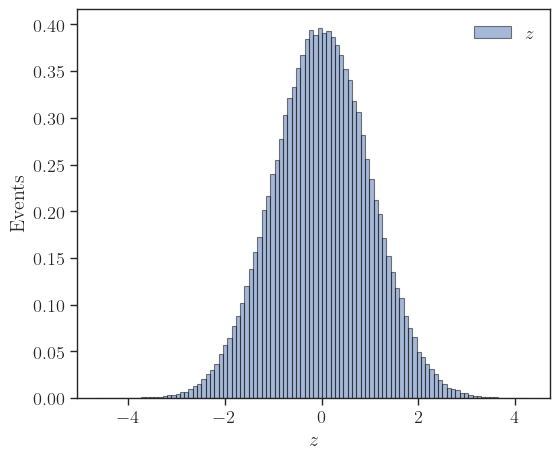

In [24]:
# Latent distribution
n_samples = 100000
z_gen = torch.randn((n_samples, n_dim))

print(z_gen.shape)

# Visualize the latent distribution
fig, ax = plt.subplots(figsize=(6,5))

ax.hist(z_gen.detach().numpy().flatten(), alpha=0.5, density=True, bins=100, label=r'$z$', edgecolor='black')

ax.set_xlabel('$z$')
ax.set_ylabel( r'$\mathrm{Events}$')
ax.legend(loc='best', frameon=False)

fig.tight_layout()

In [17]:
# Generate m2 samples from latent distribution
mp_thetap_gen, _ = inn(z_gen, rev=True)
mp_thetap_gen = mp_thetap_gen.detach().numpy()[:]

print(mp_thetap_gen.shape)
print(mp_thetap_gen[0])

(100000, 2)
[0.9076682 0.5382245]


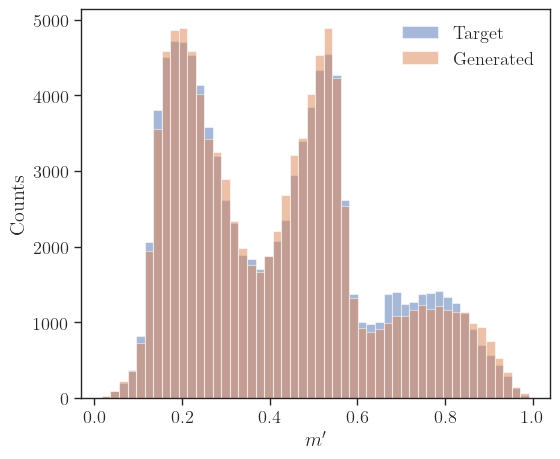

In [25]:
# Visualize 
fig, ax = plt.subplots( figsize=(6,5) )

counts, bins, _ = ax.hist(mp_thetap[:n_samples,0], 50, alpha = 0.5, label = r'$\mathrm{Target}$')
ax.hist(mp_thetap_gen[:,0], bins, alpha=0.5, label = r'$\mathrm{Generated}$')

ax.set_xlabel( r"$m'$")
ax.set_ylabel( r'$\mathrm{Counts}$' )


ax.legend(loc='best', frameon=False)

fig.tight_layout()
#fig.savefig(r'figs/D-amplitude_SDP_mp_INN_target_vs_gen_v2.pdf', dpi = 300, pad_inches = .1, bbox_inches = 'tight')
#fig.savefig(r'figs/D-amplitude_SDP_mp_INN_target_vs_gen_v2.png', dpi = 300, pad_inches = .1, bbox_inches = 'tight')

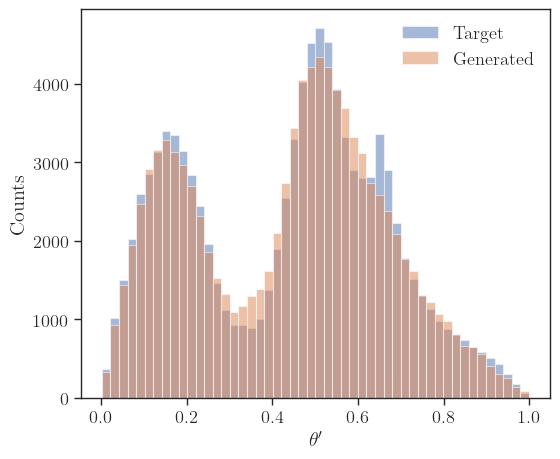

In [26]:
# Visualize 
fig, ax = plt.subplots( figsize=(6,5) )

counts, bins, _ = ax.hist(mp_thetap[:n_samples,1], 50, alpha = 0.5, label = r'$\mathrm{Target}$')
ax.hist(mp_thetap_gen[:,1], bins, alpha=0.5, label = r'$\mathrm{Generated}$')

ax.set_xlabel( r"$\theta'$")
ax.set_ylabel( r'$\mathrm{Counts}$' )


ax.legend(loc='best', frameon=False)

fig.tight_layout()
#fig.savefig(r'figs/D-amplitude_SDP_thetap_INN_target_vs_gen_v2.pdf', dpi = 300, pad_inches = .1, bbox_inches = 'tight')
#fig.savefig(r'figs/D-amplitude_SDP_thetap_INN_target_vs_gen_v2.png', dpi = 300, pad_inches = .1, bbox_inches = 'tight')

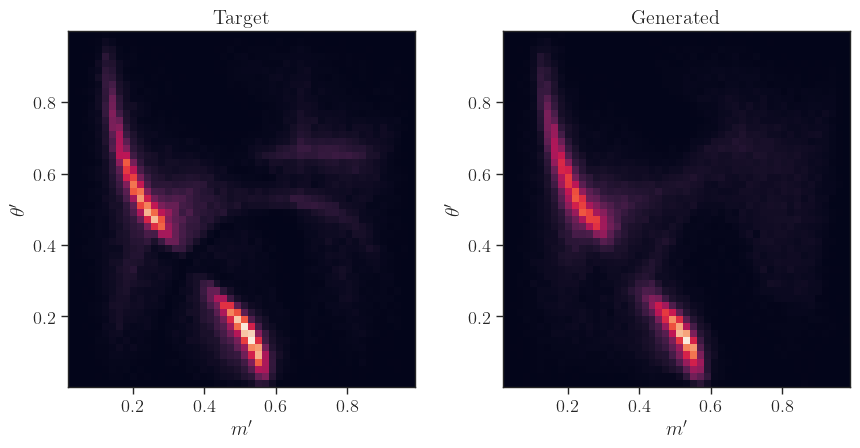

In [27]:
# Visualize 2D Dalitz plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9,5) )

h, xedges, yedges, _ = ax1.hist2d(mp_thetap[:n_samples,0], mp_thetap[:n_samples,1], 50)
ax2.hist2d(mp_thetap_gen[:,0], mp_thetap_gen[:,1], bins = [xedges, yedges])

ax1.set_xlabel(r"$m'$")
ax1.set_ylabel(r"$\theta'$")
ax1.set_title(r'$\mathrm{Target}$')
ax1.set_aspect('equal')

ax2.set_xlabel(r"$m'$")
ax2.set_ylabel(r"$\theta'$")
ax2.set_title(r'$\mathrm{Generated}$')
ax2.set_aspect('equal')

#ax.legend(loc='best', frameon=False)
fig.subplots_adjust(wspace=0, hspace=0)
fig.tight_layout()
#fig.savefig(r'figs/D-amplitude_SDP_INN_target.pdf', dpi = 300, pad_inches = .1, bbox_inches = 'tight')
#fig.savefig(r'figs/D-amplitude_SDP_INN_target.png', dpi = 300, pad_inches = .1, bbox_inches = 'tight')